In [1]:
import utils_v2 as utils
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [2]:
data = "B06" # [B05, B06, B07, B18]

In [3]:
feature = "C + VIT" # [C + V, C + VIT]

In [4]:
model = "LSTM" # [LSTM, hybrid]

In [5]:
dataDict = {
    "B05" : 0,
    "B06" : 1,
    "B07" : 2,
    "B18" : 3,
}

In [6]:
featureDict = {
    "C + V" : 0,
    "C + VIT" : 1,
    "C": 2,
}

In [7]:
modelDict = {
    "LSTM" : 0,
    "hybrid": 1
}

# Ekstraksi Data

In [8]:
dataPath = "data/NASA/"

In [9]:
x_test, y_test = utils.getData(dataPath)

In [10]:
if featureDict[feature] == 2 and modelDict[model] == 0:
    testX, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], c_only=True)
    C_LSTM_model = tf.keras.models.load_model("model/C_LSTM_model_B05_k1.h5")
    C_LSTM_pred = C_LSTM_model.predict(testX)
    inv_pred = SS.inverse_transform(C_LSTM_pred)
    pred = inv_pred.reshape(inv_pred.shape[0])
    X = range(len(inv_pred))
    pred_flat = inv_pred.flatten()

elif featureDict[feature] == 0:
    print("Feature: Single-channel ",feature)
    if modelDict[model] == 0 :
        print("Model: ", model)
        testX, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        SC_LSTM_model = tf.keras.models.load_model("model/SC_LSTM_model_B18_k2.h5")
        SC_LSTM_pred = SC_LSTM_model.predict(testX)
        inv_pred = SS.inverse_transform(SC_LSTM_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()

    elif modelDict[model] == 1:
        print("Model: ", model)
        testX_SC_h_LSTM,  SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], c = True)
        testX_SC_h_CNN,  SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        SC_hybrid_model = tf.keras.models.load_model("model/SC_CNN+LSTM_model_B07_k2.h5")
        SC_hybrid_pred = SC_hybrid_model.predict([testX_SC_h_LSTM, testX_SC_h_CNN])
        inv_pred = SS.inverse_transform(SC_hybrid_pred)  
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()

elif featureDict[feature] == 1:
    print("Feature: Multi-channel ", feature)
    if modelDict[model] == 0:
        print("Model: ", model)
        testX, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model])
        MC_LSTM_model = tf.keras.models.load_model("model/MC_LSTM_model_B06_k2.h5")
        MC_LSTM_pred = MC_LSTM_model.predict(testX)
        inv_pred = SS.inverse_transform(MC_LSTM_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()

    elif modelDict[model] == 1:
        print("Model: ", model)
        testX_MC_h_LSTM, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], c = True)
        testX_MC_h_V_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], v = True)
        testX_MC_h_I_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], II = True)
        testX_MC_h_T_CNN, SS = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10,
                                              featureDict[feature], modelDict[model], t = True)
        MC_hybrid_model = tf.keras.models.load_model("model/MC_SCNN+LSTM_model_B07_k3.h5")
        MC_hybrid_pred = MC_hybrid_model.predict([testX_MC_h_LSTM, testX_MC_h_V_CNN, testX_MC_h_I_CNN, testX_MC_h_T_CNN])
        inv_pred = SS.inverse_transform(MC_hybrid_pred)
        pred = inv_pred.reshape(inv_pred.shape[0])
        X = range(len(inv_pred))
        pred_flat = inv_pred.flatten()

Feature: Multi-channel  C + VIT
Model:  LSTM


In [11]:
failure_point = round(float(max(inv_pred)[0]*0.75), 2)
threshold = np.zeros((len(inv_pred)))
threshold.fill(failure_point)
t = threshold
failure_point

1.46

B06, C+VIT, LSTM

In [23]:
is_close_intersection = np.argwhere(np.isclose(t, pred_flat, rtol=0.001, atol=0.001)).flatten()

In [22]:
is_close_intersection

array([], dtype=int64)

In [15]:
diff_intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
diff_intersection

array([70], dtype=int64)

In [12]:
if featureDict[feature]== 0 and dataDict[data] == 1:
    intersection = np.argwhere(np.isclose(t, pred_flat, rtol=0.01, atol=0.001)).flatten()
# elif dataDict[data] == 3:
#     intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
elif dataDict[data] == 0:
    intersection = np.argwhere(np.isclose(t, pred_flat, rtol=0.001, atol=0.001)).flatten()
elif dataDict[data] == 3 and modelDict[model] == 1 and featureDict[feature] == 0:
    intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
    intersection = intersection + 1
# elif dataDict[data] == 3:
#     intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()
else:
    intersection = np.argwhere(np.diff(np.sign(t - pred_flat))).flatten()

In [32]:
intersection

array([70], dtype=int64)

In [16]:
%matplotlib inline
%matplotlib notebook

In [17]:
import matplotlib.gridspec as gridspec

<IPython.core.display.Javascript object>


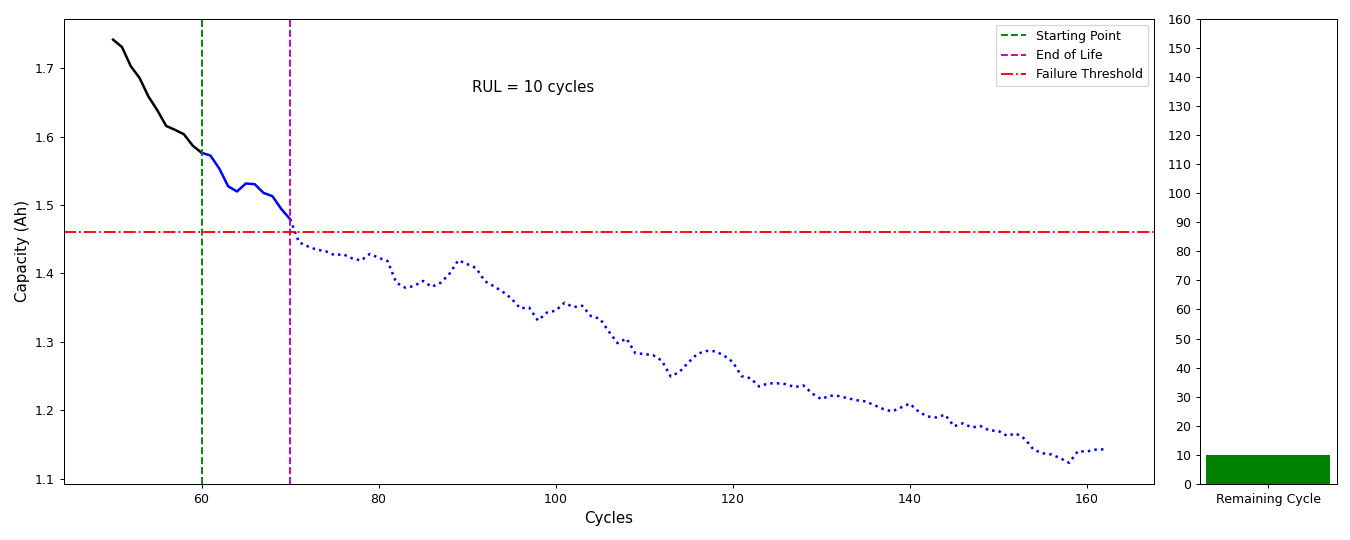

In [18]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[8,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
try:
    if dataDict[data] == 1 and featureDict[feature] == 1 and modelDict[model] == 0:
        starting_point = 60
        ax1.plot(X[50:starting_point+1], pred_flat[50:starting_point+1], linewidth=2, color='k')
        ax1.plot(X[starting_point:intersection[-1]+1], pred_flat[starting_point:intersection[-1]+1], linewidth=2, color='b')
        ax1.axvline(x=starting_point, color='g', ls='--', label="Starting Point")
    else:
        starting_point = 80
        ax1.plot(X[60:starting_point+1], pred_flat[60:starting_point+1], linewidth=2, color='k')
        ax1.plot(X[starting_point:intersection[-1]+1], pred_flat[starting_point:intersection[-1]+1], linewidth=2, color='b')        
        ax1.axvline(x=starting_point, color='g', ls='--', label="Starting Point")
        
    ax1.plot(X[intersection[-1]:], pred_flat[intersection[-1]:], linewidth=2, color='b', ls=':')
    ax1.axvline(intersection[-1], color='m', ls='--', label="End of Life")

    ax1.axhline(y=failure_point, color='r', ls='-.', label="Failure Threshold")

    ax1.set_ylabel("Capacity (Ah)", fontsize=12)
    ax1.set_xlabel("Cycles", fontsize=12)

    # ax2 = fig.add_subplot(122)
    ax2.bar(['Remaining Cycle'], [intersection[-1]-starting_point], color = 'g')
    ax2.set_yticks(np.arange(0, max(X), 10));
    
    text = f"RUL = {intersection[-1]-starting_point} cycles"
    
    # jika pakai legend
    ax1.legend()
    
    # jika pakai anotasi 
    if dataDict[data] == 0:
#         plt.gcf().text(0.12, 0.5, "Starting Cycle", fontsize=12);
        if featureDict[feature] == 2:
            plt.gcf().text(0.34, 0.7, text, fontsize=12)
        elif modelDict[model] == 1 and featureDict[feature] == 0:
            plt.gcf().text(0.34, 0.7, text, fontsize=12)
            pass
#             plt.gcf().text(0.45, 0.5, "End of Life", fontsize=12); # sc hybrid
        elif modelDict[model] == 0 and featureDict[feature] == 0:
            plt.gcf().text(0.34, 0.7, text, fontsize=12)
            pass
#             plt.gcf().text(0.44, 0.5, "End of Life", fontsize=12); # sc lstm
        elif modelDict[model] == 1 and featureDict[feature] == 1:
            plt.gcf().text(0.34, 0.7, text, fontsize=12)
            pass
#             plt.gcf().text(0.485, 0.5, "End of Life", fontsize=12); # mc hybrid
        else:
            plt.gcf().text(0.3, 0.7, text, fontsize=12)
#             plt.gcf().text(0.46, 0.5, "End of Life", fontsize=12); # mc lstm
    elif dataDict[data] == 1:
        plt.gcf().text(0.35, 0.83, text, fontsize=12)
#         plt.gcf().text(0.12, 0.52, "Starting Cycle", fontsize=12);
#         if featureDict[feature] == 2:
#             plt.gcf().text(0.26, 0.88, text, fontsize=12)
#         elif modelDict[model] == 0 and featureDict[feature] == 0:
#             plt.gcf().text(0.23, 0.83, text, fontsize=12)
# #             plt.gcf().text(0.36, 0.7, "End of Life", fontsize=12); # sc lstm
#         elif modelDict[model] == 1 and featureDict[feature] == 1:
#             plt.gcf().text(0.28, 0.83, text, fontsize=12)
# #             plt.gcf().text(0.45, 0.7, "End of Life", fontsize=12); # mc hybrid
#         elif modelDict[model] == 0 and featureDict[feature] == 1:
#             plt.gcf().text(0.5, 0.83, text, fontsize=12)
# #             plt.gcf().text(0.3, 0.7, "End of Life", fontsize=12); # mc lstm
#         else:
#             plt.gcf().text(0.3, 0.83, text, fontsize=12)
#             plt.gcf().text(0.5, 0.7, "End of Life", fontsize=12); # sc hybrid
    elif dataDict[data] == 3:
#         plt.gcf().text(0.19, 0.35, "Starting Cycle", fontsize=12);
        if modelDict[model] == 0 and featureDict[feature] == 0:
            plt.gcf().text(0.45, 0.83, text, fontsize=12)
#             plt.gcf().text(0.6, 0.7, "End of Life", fontsize=12); # sc lstm
        elif modelDict[model] == 1 and featureDict[feature] == 1:
            plt.gcf().text(0.45, 0.83, text, fontsize=12)
#             plt.gcf().text(0.62, 0.7, "End of Life", fontsize=12); # mc hybrid
        else:
            plt.gcf().text(0.37, 0.83, text, fontsize=12)
#             plt.gcf().text(0.553, 0.7, "End of Life", fontsize=12); # sc hybrid
    
except Exception as e:
    ax1.plot(X, pred_flat, linewidth=2, color='k', label="Prediction")
    ax1.axhline(y=failure_point, color='r', ls='-.', label="Failure Threshold")
    ax1.set_yticks(np.arange(1.4, max(pred_flat), 0.15));
    ax2.set_yticks(np.arange(0, max(X), 10));
    ax2.set_xticks([1]);
    ax1.set_ylabel("Capacity (Ah)", fontsize=12)
    ax1.set_xlabel("Cycles", fontsize=12)
    ax2.set_xlabel("Remaining cycles", fontsize=12)
    ax1.legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


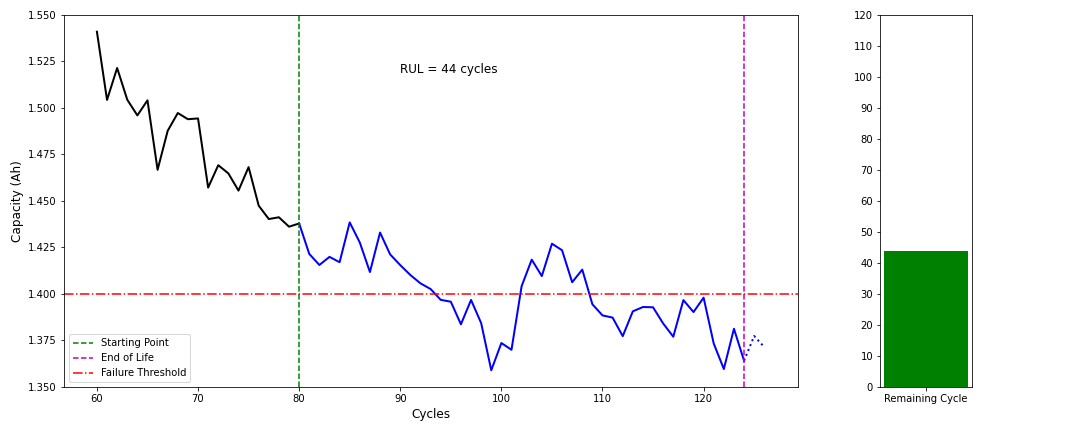

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [8, 1]})
try: 
    ax1.plot(X[60:81], pred_flat[60:81], linewidth=2, color='k')
    ax1.plot(X[80:intersection[-1]+1], pred_flat[80:intersection[-1]+1], linewidth=2, color='b')
    ax1.plot(X[intersection[-1]:], pred_flat[intersection[-1]:], linewidth=2, color='b', ls=':')

    ax1.axvline(x=80, color='g', ls='--', label="Starting Point")
    ax1.axvline(intersection[-1], color='m', ls='--', label="End of Life")

    ax1.axhline(y=1.4, color='r', ls='-.', label="Failure Threshold")

    ax1.set_ylabel("Capacity (Ah)", fontsize=12)
    ax1.set_xlabel("Cycles", fontsize=12)

    # ax2 = fig.add_subplot(122)
    ax2.bar(['Remaining Cycle'], [intersection[-1]-80], color = 'g')
    ax2.set_yticks(np.arange(0, max(X), 10));
    
    text = f"RUL = {intersection[-1]-80} cycles"
    
    # jika pakai legend
    ax1.legend()
    
    # jika pakai anotasi 
    if dataDict[data] == 0:
        plt.gcf().text(0.3, 0.7, text, fontsize=12)
#         plt.gcf().text(0.12, 0.5, "Starting Cycle", fontsize=12);
        if modelDict[model] == 1 and featureDict[feature] == 0:
            pass
#             plt.gcf().text(0.45, 0.5, "End of Life", fontsize=12); # sc hybrid
        elif modelDict[model] == 0 and featureDict[feature] == 0:
            pass
#             plt.gcf().text(0.44, 0.5, "End of Life", fontsize=12); # sc lstm
        elif modelDict[model] == 1 and featureDict[feature] == 1:
            pass
#             plt.gcf().text(0.485, 0.5, "End of Life", fontsize=12); # mc hybrid
        else:
            pass
#             plt.gcf().text(0.46, 0.5, "End of Life", fontsize=12); # mc lstm
    elif dataDict[data] == 1:
#         plt.gcf().text(0.12, 0.52, "Starting Cycle", fontsize=12);
        if modelDict[model] == 0 and featureDict[feature] == 0:
            plt.gcf().text(0.23, 0.83, text, fontsize=12)
#             plt.gcf().text(0.36, 0.7, "End of Life", fontsize=12); # sc lstm
        elif modelDict[model] == 1 and featureDict[feature] == 1:
            plt.gcf().text(0.28, 0.83, text, fontsize=12)
#             plt.gcf().text(0.45, 0.7, "End of Life", fontsize=12); # mc hybrid
        elif modelDict[model] == 0 and featureDict[feature] == 1:
            plt.gcf().text(0.28, 0.83, text, fontsize=12)
#             plt.gcf().text(0.3, 0.7, "End of Life", fontsize=12); # mc lstm
        else:
            plt.gcf().text(0.3, 0.83, text, fontsize=12)
#             plt.gcf().text(0.5, 0.7, "End of Life", fontsize=12); # sc hybrid
    elif dataDict[data] == 3:
#         plt.gcf().text(0.19, 0.35, "Starting Cycle", fontsize=12);
        if modelDict[model] == 0 and featureDict[feature] == 0:
            plt.gcf().text(0.45, 0.83, text, fontsize=12)
#             plt.gcf().text(0.6, 0.7, "End of Life", fontsize=12); # sc lstm
        elif modelDict[model] == 1 and featureDict[feature] == 1:
            plt.gcf().text(0.45, 0.83, text, fontsize=12)
#             plt.gcf().text(0.62, 0.7, "End of Life", fontsize=12); # mc hybrid
        else:
            plt.gcf().text(0.37, 0.83, text, fontsize=12)
#             plt.gcf().text(0.553, 0.7, "End of Life", fontsize=12); # sc hybrid
    
except Exception as e:
    ax1.plot(X, pred_flat, linewidth=2, color='k')
    ax1.set_yticks(np.arange(1.4, max(pred_flat), 0.15));
    ax2.set_yticks(np.arange(0, max(X), 10));
    ax2.set_xticks([1]);
    ax1.set_ylabel("Capacity (Ah)", fontsize=12)
    ax1.set_xlabel("Cycles", fontsize=12)
    ax2.set_xlabel("Remaining cycles", fontsize=12)

fig.tight_layout()
plt.subplots_adjust(right=0.9,
                    wspace=0.2)

In [17]:
text = f"RUL = {intersection[-1]-80} cycles"

In [18]:
print(text)

RUL = 23 cycles


In [43]:
from PyQt5.QtCore import Qt
help(Qt)

Help on class Qt in module PyQt5.QtCore:

class Qt(sip.simplewrapper)
 |  Method resolution order:
 |      Qt
 |      sip.simplewrapper
 |      builtins.object
 |  
 |  Data descriptors defined here:
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  AA_CompressHighFrequencyEvents = 25
 |  
 |  AA_CompressTabletEvents = 29
 |  
 |  AA_DisableHighDpiScaling = 21
 |  
 |  AA_DisableNativeVirtualKeyboard = 9
 |  
 |  AA_DisableSessionManager = 31
 |  
 |  AA_DisableShaderDiskCache = 27
 |  
 |  AA_DisableWindowContextHelpButton = 30
 |  
 |  AA_DontCheckOpenGLContextThreadAffinity = 26
 |  
 |  AA_DontCreateNativeWidgetSiblings = 4
 |  
 |  AA_DontShowIconsInMenus = 2
 |  
 |  AA_DontShowShortcutsInContextMenus = 28
 |  
 |  AA_DontUseNativeDialogs = 23
 |  
 |  AA_DontUseNativeMenuBar = 6
 |  
 |  AA_EnableHighDpiScaling = 20
 |

In [44]:
import PyQt5

In [46]:
PyQt5.QtCore_

AttributeError: module 'PyQt5.QtCore' has no attribute '__version__'